In [1]:
import numpy as np
import math
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,Aer, transpile, execute
from qiskit.visualization import plot_histogram

# Exactly-1 3-SAT problem
##### Exactly-1 3-SAT problem is a variant of 3SAT problem where the input instance is the same but the question is to determine whether there exists a satisfying solution so that exactly one literal in each clause is set to 1.
### F(x1,x2,x3) = (x1 V x2 V ~x3) & (~x1 V ~x2 ~ x3) & (~x1 V x2 V x3)

NOTE: (x1V ~ x2 V x3) is equivalent to = X1 xor ~X2 xor X3 xor (X1 & ~X2 & X3)

In [2]:
#Input superposition for grover's algorithm
def input_state(circuit,f_in,f_out,n):
    for i in range(n):
        circuit.h(f_in[i])
    circuit.x(f_out)
    circuit.h(f_out)
    circuit.barrier()
    return circuit

#Oracle to mark the solution
def oracle(circuit,f_in,f_out,n,sat_formula):
    num_clauses = len(sat_formula)
    
    for (k,clause) in enumerate(sat_formula):
        
        for i in range(len(clause)):
            #for positive literals
            if clause[i]>0:
                circuit.cx(f_in[i],aux[k])
            #for negative literals
            else:
                circuit.x(f_in[i])
                circuit.cx(f_in[i],aux[k])
        
        #storing the solution of each clause in a auxillary qubit
        circuit.ccx(f_in[0],f_in[1],aux[num_clauses])
        circuit.ccx(f_in[2],aux[num_clauses],aux[k])
        #flipping the aux[num_clauses] back so that it can be reused for next clause
        circuit.ccx(f_in[0],f_in[1],aux[num_clauses])
        #flipping back the negative literals
        for i in range(len(clause)):
            if clause[i]<0:
                circuit.x(f_in[i])
        circuit.barrier()   
    
    #storing the final solution from auxillary qubits to f_out
    if num_clauses==1:
        circuit.cx(aux[0],f_out[0])
    elif num_clauses==2:
        circuit.ccx(aux[0],aux[1],f_out[0])
    elif num_clauses==3:
        circuit.ccx(aux[0],aux[1],aux[num_clauses])
        circuit.ccx(aux[2],aux[num_clauses],f_out[0])
        circuit.ccx(aux[0],aux[1],aux[num_clauses])
        
    #Restoring all the ancillary qubits
    for (k,clause) in enumerate(sat_formula):
        for i in range(len(clause)):
            if clause[i]>0:
                circuit.cx(f_in[i],aux[k])
            else:
                circuit.x(f_in[i])
                circuit.cx(f_in[i],aux[k])
        circuit.ccx(f_in[0],f_in[1],aux[num_clauses])
        circuit.ccx(f_in[2],aux[num_clauses],aux[k])
        circuit.ccx(f_in[0],f_in[1],aux[num_clauses])
        for i in range(len(clause)):
            if clause[i]<0:
                circuit.x(f_in[i])
    circuit.barrier()    
    return circuit

#Diffusion operator
def diff_operator(circuit,f_in,n):
    for i in range(n):
        circuit.h(f_in[i])
        circuit.x(f_in[i])
    circuit.h(f_in[-1])
    circuit.mct([f_in[i] for i in range(n-1)],f_in[-1])
    for i in range(n):
        circuit.h(f_in[i])
        circuit.x(f_in[i])
    circuit.h(f_in[-1])
    qc.barrier()
    return circuit
    

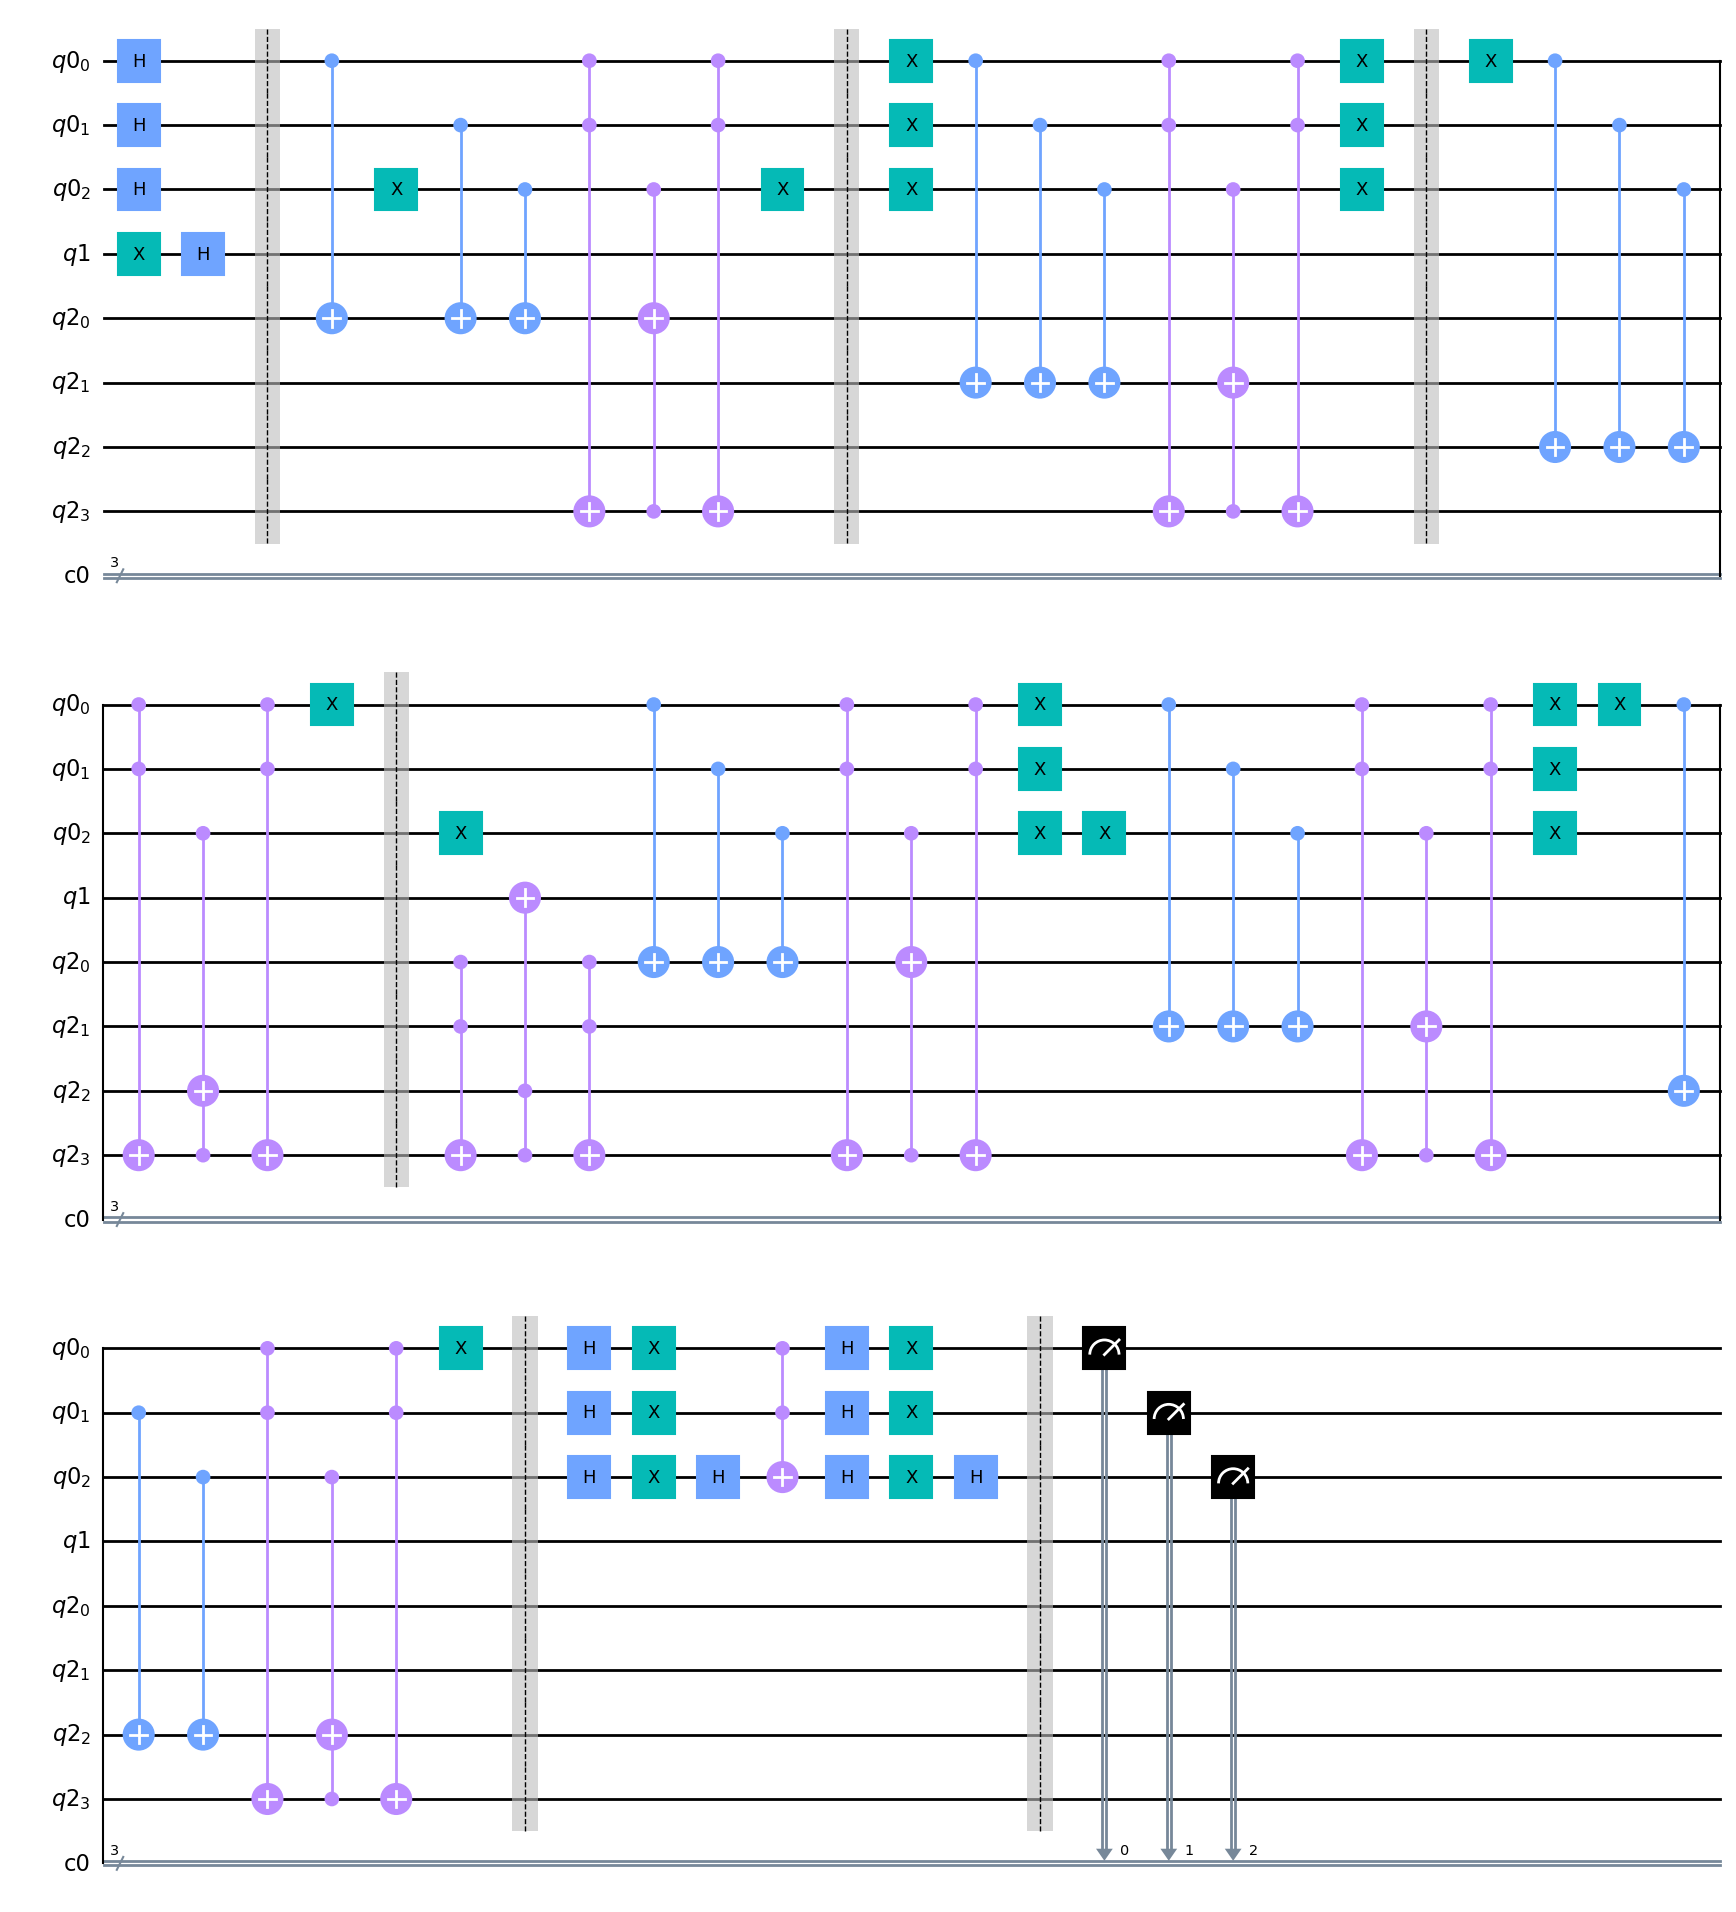

In [3]:
sat_formula = [[1,2,-3],[-1,-2,-3],[-1,2,3]]
n = max(len(i) for i in sat_formula)
max_iter = np.pi*np.sqrt((2**n))/4 - 0.5

f_in = QuantumRegister(n)  #qubits to encode sat_formula
f_out = QuantumRegister(1) #qubit to store final solution
aux = QuantumRegister(len(sat_formula)+1)  #auxillary qubits to store solution of each clause in sat_formula
ans = ClassicalRegister(n)

qc = QuantumCircuit(f_in,f_out,aux,ans)
input_state(qc,f_in,f_out,n)
for i in range(math.floor(max_iter)):
    oracle(qc,f_in,f_out,n,sat_formula)
    diff_operator(qc,f_in,n)
qc.measure(f_in[:],ans[:])
qc.draw('mpl')


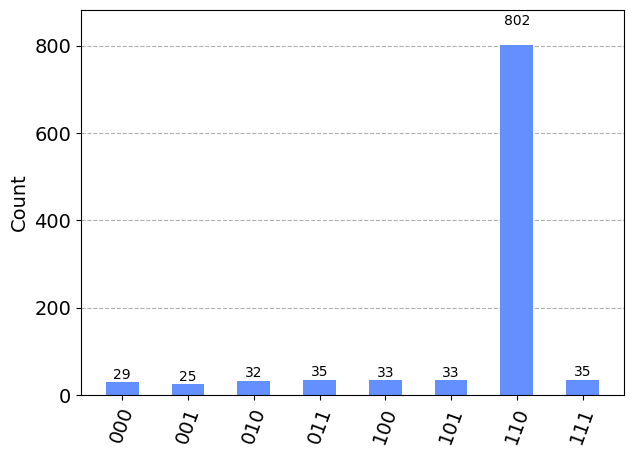

In [4]:
result = execute(qc,Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(result)